In [1]:
import os
import pickle
from tqdm import tqdm 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import norm


In [2]:
pd.__version__

'1.3.3'

# RQ2 - sentiment analysis
We investigate the following two sub research questions:
- RQ2.1: Does the media/quoters opinion on a certain movie affect the amount of sold tickets?
- RQ2.2: Does the sentiment seen in quotes relate to the rating on IMDB?

### Initial analyses
We will start by investigating three different approaches for adding sentiment scores
to quotes. One uses the simpler dictionary-based sentiment ranking system of
the [AFINN lexicon](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf). Another is the [VADER sentiment module](https://github.com/cjhutto/vaderSentiment) that was used in the tutorial on text handling. This is lexicon- and rule-based and tuned to sentiments occuring in textual data from socia media and has the advantage to AFINN that it includes the negative, neutral, positive as well as the compound (combined and scaled between -1 and 1) sentiment scores of a string whereas this should be manually handled with AFINN. The last approach uses
the nowadays hyped transformers, where a pretrained transformer
from [HuggingFace](https://github.com/huggingface/transformers) determined to use the distilled BERT model that is unsenstive to the case of words (the default model). We choose to stay with the default pretrained model as the distillation makes it faster and the unsensitiveness to casing as we want to examine quotes and not online textual expressions as tweets. With the latter we mean that the casing is redundant to incorporate when dealing with spoken text compared to written text expressions - as an example the case sensitive model would be of interest to use for tweets where "FUCK" and "fuck" should definitely be related to different scores. The default model the model `distilbert-base-uncased` and we would like to refer to the [paper accompanying the model](https://arxiv.org/abs/1910.01108) for more technical details.

In general we put more weight on the VADER and Transformer approaches as they are less naïve but we keep the AFINN as an option that might be a "funny" feature for interactive plots.

In [3]:
#!pip install Afinn
#!pip install transformers[sentencepiece]

In [4]:
from afinn import Afinn 
afn = Afinn()

In [5]:
#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vaderAnalyzer = SentimentIntensityAnalyzer()

In [6]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


We initially test the approaches on a couple of examples to get an idea of how and whether they work or not. A helper function for the AFINN and VADER objects is used for similar output as the transformer.

In [7]:
def output_aux(score, threshold=0):
    """Helper function for outputting similar output as the transformer."""
    
    if score < threshold:
        prediction_dict = [{'label': 'NEGATIVE', 'score': score}]
    else:
        prediction_dict = [{'label': 'POSITIVE', 'score': score}]
        
    return prediction_dict

In [8]:
negative_sentence = "Fuck you fucking dumb BERT model, you dumbass"
print(f'"{negative_sentence}":\n Transformer: \t {classifier(negative_sentence)}\n AFINN:\t\t {output_aux(afn.score(negative_sentence))}\n VADER: \t {output_aux(vaderAnalyzer.polarity_scores(negative_sentence)["compound"])}\n')

positive_sentence = "I love my ADA group - they're the best! <3"
print(f'"{positive_sentence}":\n Transformer: \t {classifier(positive_sentence)}\n AFINN:\t\t {output_aux(afn.score(positive_sentence))}\n VADER: \t {output_aux(vaderAnalyzer.polarity_scores(positive_sentence)["compound"])}\n')

"Fuck you fucking dumb BERT model, you dumbass":
 Transformer: 	 [{'label': 'NEGATIVE', 'score': 0.9992602467536926}]
 AFINN:		 [{'label': 'NEGATIVE', 'score': -14.0}]
 VADER: 	 [{'label': 'NEGATIVE', 'score': -0.8932}]

"I love my ADA group - they're the best! <3":
 Transformer: 	 [{'label': 'POSITIVE', 'score': 0.9998805522918701}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 6.0}]
 VADER: 	 [{'label': 'POSITIVE', 'score': 0.9117}]



Based on this single (however super representative!!!) example we see that all three approaches work but that the output scores are quite differently scaled. This is due to the fact that the transformer has a softmax layer in the end and therefore outputs the probability of the most probable label - which is either "POSITIVE" or "NEGATIVE". On the other hand AFINN accumulates a the score of both positive and negative words to get a single score. The AFINN score can thus strongly depend on the length of a sentence and we would need to introduce a normalization term. The VADER scores are as mentioned pre-scaled and normalized in the range between -1 and 1 in the module implementation.

In [9]:
symbols = ['<3', ':-)', ':-(']

for sym in symbols:
    print(f'"{sym}":\n Transformer: \t {classifier(sym)}\n AFINN:\t\t {output_aux(afn.score(sym))}\n VADER: \t {output_aux(vaderAnalyzer.polarity_scores(sym)["compound"])}\n')

"<3":
 Transformer: 	 [{'label': 'POSITIVE', 'score': 0.979346513748169}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 0.0}]
 VADER: 	 [{'label': 'POSITIVE', 'score': 0.4404}]

":-)":
 Transformer: 	 [{'label': 'POSITIVE', 'score': 0.5607805848121643}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 0.0}]
 VADER: 	 [{'label': 'POSITIVE', 'score': 0.3182}]

":-(":
 Transformer: 	 [{'label': 'NEGATIVE', 'score': 0.87599778175354}]
 AFINN:		 [{'label': 'POSITIVE', 'score': 0.0}]
 VADER: 	 [{'label': 'NEGATIVE', 'score': -0.3612}]



As seen above some of the approaches differ when examining symbols like smileys and hearts. Here, the manually defined AFINN lexicon can not encounter such tokens, where the transformer on the contrary has learned to encounter these and in fact do quite a good job (except for the 'positive' smiley). The rule-based lexicon of VADER has indeed also learned the mapping of such smileys and symbols. Even though symbols like these are not immediately associated with quotes - as quotes are text capturing spoken language - it might come in as a good feature that the transformer and the VADER approaches are more complex and understand the local sentiment of subtokens better than AFINN. We therefore already disregard AFINN as the better approach but keep it as a possible feature for interactive plots as previously mentioned. We will investigate the other two a bit more and apply all three scores to a new dataframe.

### Applying sentiment scores to the data (skipable)
This section can be skipped if it has previously been executed!

First, we load the data that was previously processed. The pickled file was created with pandas 1.3.3. and has to be loaded with the same pandas version.

In [10]:
# Specifying filename and directory
data_dir = os.getcwd() + os.sep + 'data'
filepath = rf"{data_dir}{os.sep}Quotebank_wSentiment.pkl"

df = pd.read_pickle(filepath)
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,sentiment
0,"with the short and said, `We'd like to go with...",Al Jean,[Q2829373],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,Onward,3832,6.0
1,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,Onward,1151,5.0
2,Sonic the Hedgehog might not become a kid-movi...,Brian Truitt,[Q24387573],2020-02-14,1,"[[None, 0.7308], [Brian Truitt, 0.179], [Micha...",[http://www.gamespot.com/articles/sonic-the-he...,Sonic the Hedgehog,3155,5.0
3,The animals do what he wants but operate in co...,Stephen Gaghan,[Q1971984],2020-01-24,1,"[[Stephen Gaghan, 0.7508], [None, 0.2492]]",[http://nst.com.my/lifestyle/groove/2020/01/55...,Dolittle,2035,-5.0
4,`Dolittle' is a more harmless and whimsical fa...,Robert Downey,[Q165219],2020-01-18,1,"[[Robert Downey, 0.6829], [None, 0.2553], [Kat...",[http://gulfnews.com/entertainment/hollywood/r...,Dolittle,1168,0.0


Now we compute the sentiment scores with AFINN score, VADER score and the BERT transformer based score. We do two things here; first we redefine the auxiliary function used to change the output format such that it normalizes the sentiment by the length of a quote (defined by number of words splitted at whitespaces) when using AFINN and second we are aware that the transformer is limited to a certain input sequence length and add a NaN-value for a quote if it is longer than this maximum sequence length. Later we will try to scale the different scores such that they are comparable.

In [11]:
def afn_aux(quote):
    """Helper function for outputting similar output as the transformer."""
    
    score = afn.score(quote) / len(quote.split(" "))

    if score < 0:
        prediction_dict = [{'label': 'NEGATIVE', 'score': score}]
    else:
        prediction_dict = [{'label': 'POSITIVE', 'score': score}]
        
    return prediction_dict

In [12]:
sentiments_AFINN = [afn_aux(quote) for quote in tqdm(df.quotation)]

100%|███████████████████████████████████████████████████████████████████████████| 44970/44970 [01:44<00:00, 431.72it/s]


In [13]:
sentiments_VADER = [output_aux(vaderAnalyzer.polarity_scores(quote)['compound']) for quote in tqdm(df.quotation)]

100%|███████████████████████████████████████████████████████████████████████████| 44970/44970 [00:47<00:00, 945.38it/s]


In [14]:
# the model is limited to handling sequences of a prespecified length.
# We handle this by using the try-except statement and add a nan-value where the 
# BERT can't handle the input quote.
sentiments_BERT = []
for quote in tqdm(df.quotation):
    try:
        BERT_score = classifier(quote)
        sentiments_BERT.append(BERT_score)
    except RuntimeError:
        sentiments_BERT.append(np.nan)

100%|██████████████████████████████████████████████████████████████████████████| 44970/44970 [1:15:53<00:00,  9.88it/s]


Let's visualize the first 5 rows of the dataframe to see how the sentiment attributes look. We save a new pickle with the sentiments scores included for faster processing time in the future.

In [15]:
df['sentiment_AFINN'] = sentiments_AFINN
df['sentiment_VADER'] = sentiments_VADER
df['sentiment_BERT'] = sentiments_BERT

df = df.drop(['sentiment'], axis=1)
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,sentiment_AFINN,sentiment_VADER,sentiment_BERT
0,"with the short and said, `We'd like to go with...",Al Jean,[Q2829373],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,Onward,3832,"[{'label': 'POSITIVE', 'score': 0.285714285714...","[{'label': 'POSITIVE', 'score': 0.7003}]","[{'label': 'POSITIVE', 'score': 0.999715507030..."
1,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,Onward,1151,"[{'label': 'POSITIVE', 'score': 0.135135135135...","[{'label': 'POSITIVE', 'score': 0.6996}]","[{'label': 'POSITIVE', 'score': 0.999764025211..."
2,Sonic the Hedgehog might not become a kid-movi...,Brian Truitt,[Q24387573],2020-02-14,1,"[[None, 0.7308], [Brian Truitt, 0.179], [Micha...",[http://www.gamespot.com/articles/sonic-the-he...,Sonic the Hedgehog,3155,"[{'label': 'POSITIVE', 'score': 0.166666666666...","[{'label': 'POSITIVE', 'score': 0.8899}]","[{'label': 'POSITIVE', 'score': 0.999813258647..."
3,The animals do what he wants but operate in co...,Stephen Gaghan,[Q1971984],2020-01-24,1,"[[Stephen Gaghan, 0.7508], [None, 0.2492]]",[http://nst.com.my/lifestyle/groove/2020/01/55...,Dolittle,2035,"[{'label': 'NEGATIVE', 'score': -0.08333333333...","[{'label': 'NEGATIVE', 'score': -0.7351}]","[{'label': 'NEGATIVE', 'score': 0.973637342453..."
4,`Dolittle' is a more harmless and whimsical fa...,Robert Downey,[Q165219],2020-01-18,1,"[[Robert Downey, 0.6829], [None, 0.2553], [Kat...",[http://gulfnews.com/entertainment/hollywood/r...,Dolittle,1168,"[{'label': 'POSITIVE', 'score': 0.0}]","[{'label': 'POSITIVE', 'score': 0.4974}]","[{'label': 'POSITIVE', 'score': 0.992860138416..."


We check how many NaN values we created by use of the transformer and remove them. The justification for this is mainly that we do not have time for training a new model and prefer using a pretrained one that has already shown a prominent performance and that it seems plausible that (super) long quotes are erroneous data that has not been removed in the Quotebank approach of scraping the quotes from newspaper articles. Below we print out 3 random of the 88 quotes that were too long for the transformer to handle.

In [16]:
print(f"Number of NaN-values in BERT sentiment score: {df.isnull().any(axis=1).sum()}")

Number of NaN-values in BERT sentiment score: 88


In [17]:
NaN_quotes = df[df.isnull().any(axis=1)]

random_ids = np.random.randint(0, len(NaN_quotes), size=3)
for random_id in random_ids:
    print(f"{NaN_quotes.quotation.iloc[random_id]}\n")

Just because someone stumbles and loses their path, doesn't mean they can't be saved. „ ~ Professor X Trivia Although he is a hero in the main X-Men series, he is a villain in the Marvel Noir X-Men series. Gallery Professor X as seen in the 1993 animated X-Men Cartoons Professor X as seen in X-Men Evolution Xavier in Wolverine and the X-Men Professor X in X-Men Anime Charles Xavier in Spider-Man and His Amazing Friends Professor X in Pryde of the X-Men Professor X as played by Patrick Stewart in the X-Men live action films. Charles Xavier in X-Men First Class Xavier in X-Men Days of Future Past Young Xavier in Days of Future Past Professor X in Ultimate Alliance Add a photo to this gallery Navigation X-Men Archangel | Anole | Armor | Banshee | Beast | Bishop | Blindfold | Boom-Boom | Cable | Caliban | Cannonball | Chamber | Changeling | Cypher | Colossus | Cyclops | Darwin | Dazzler | Dust | Elixir | Emma Frost | Fantomex | Firestar | Forge | Gambit | Gentle | Graymalkin | Havok | Hell

In [18]:
df = df.loc[-df.isnull().any(axis=1)]
df.index = np.arange(len(df))

df.isnull().any()

quotation          False
speaker            False
qids               False
date               False
numOccurrences     False
probas             False
urls               False
movie              False
shared_ID          False
sentiment_AFINN    False
sentiment_VADER    False
sentiment_BERT     False
dtype: bool

In [19]:
import time
# Save loaded DataFrame as pickle for faster loading time in the future
time = int(np.round(time.time()))
filename = f"Quotebank_newSentiments_{time}"
df.to_pickle(rf"{data_dir}{os.sep}{filename}.pkl")
print(f"Dataframe was pickled and saved to directory:\n{data_dir} \n")
print(f"Shape of dataframe: {df.shape}")

Dataframe was pickled and saved to directory:
C:\Users\Albert Kjøller\ada-2021-project-f-jab\data 

Shape of dataframe: (44882, 12)


### Investigating the sentiment attributes (specific)

We now want to investigate the distribution of the sentiment scores for each of the approaches. We will invest all of the three but with an emphasis on VADER and the Transformer-based approach. We start by extracting the scores and label from the dictionary structure that the scores are stored and vizualising the distribution of the BERT and VADER sentiments before re-scaling them.

In [10]:
data_dir = os.getcwd() + os.sep + 'data'
filename = f"Quotebank_newSentiments_1638718740"
df = pd.read_pickle(rf"{data_dir}{os.sep}{filename}.pkl")
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,sentiment_AFINN,sentiment_VADER,sentiment_BERT
0,"with the short and said, `We'd like to go with...",Al Jean,[Q2829373],2020-02-28,1,"[[None, 0.6415], [Al Jean, 0.3585]]",[https://comicbook.com/tv-shows/2020/02/28/the...,Onward,3832,"[{'label': 'POSITIVE', 'score': 0.285714285714...","[{'label': 'POSITIVE', 'score': 0.7003}]","[{'label': 'POSITIVE', 'score': 0.999715507030..."
1,Thrilled to announce that I will perform the e...,Brandi Carlile,[Q164060],2020-02-19,1,"[[Brandi Carlile, 0.543], [None, 0.3348], [Myc...",[https://klaw.com/brandi-carlile-carried-me-wi...,Onward,1151,"[{'label': 'POSITIVE', 'score': 0.135135135135...","[{'label': 'POSITIVE', 'score': 0.6996}]","[{'label': 'POSITIVE', 'score': 0.999764025211..."
2,Sonic the Hedgehog might not become a kid-movi...,Brian Truitt,[Q24387573],2020-02-14,1,"[[None, 0.7308], [Brian Truitt, 0.179], [Micha...",[http://www.gamespot.com/articles/sonic-the-he...,Sonic the Hedgehog,3155,"[{'label': 'POSITIVE', 'score': 0.166666666666...","[{'label': 'POSITIVE', 'score': 0.8899}]","[{'label': 'POSITIVE', 'score': 0.999813258647..."
3,The animals do what he wants but operate in co...,Stephen Gaghan,[Q1971984],2020-01-24,1,"[[Stephen Gaghan, 0.7508], [None, 0.2492]]",[http://nst.com.my/lifestyle/groove/2020/01/55...,Dolittle,2035,"[{'label': 'NEGATIVE', 'score': -0.08333333333...","[{'label': 'NEGATIVE', 'score': -0.7351}]","[{'label': 'NEGATIVE', 'score': 0.973637342453..."
4,`Dolittle' is a more harmless and whimsical fa...,Robert Downey,[Q165219],2020-01-18,1,"[[Robert Downey, 0.6829], [None, 0.2553], [Kat...",[http://gulfnews.com/entertainment/hollywood/r...,Dolittle,1168,"[{'label': 'POSITIVE', 'score': 0.0}]","[{'label': 'POSITIVE', 'score': 0.4974}]","[{'label': 'POSITIVE', 'score': 0.992860138416..."


In [11]:
# Extracting sentiment scores and labels from the 
VADER_scores = pd.Series([score_dict[0]['score'] for score_dict in df.sentiment_VADER])
VADER_labels = pd.Series([score_dict[0]['label'] for score_dict in df.sentiment_VADER])

BERT_scores = pd.Series([score_dict[0]['score'] for score_dict in df.sentiment_BERT])
BERT_labels = pd.Series([score_dict[0]['label'] for score_dict in df.sentiment_BERT])

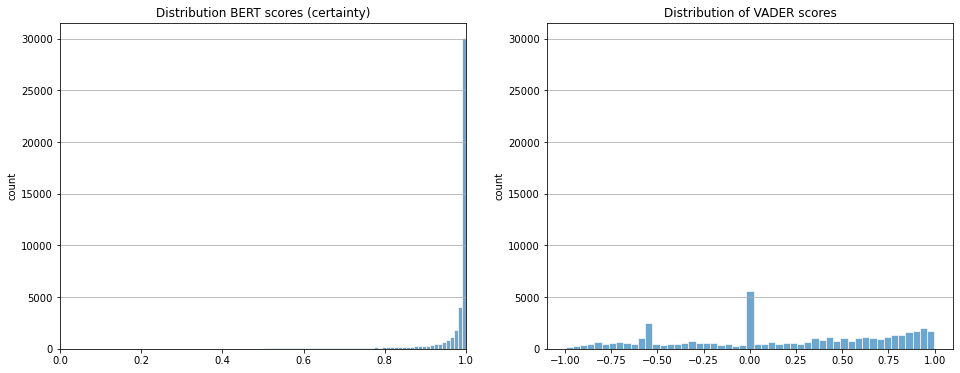

In [12]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
BERT_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax1.set_xlim(0,1)
ax1.set_ylabel("count")
ax1.xaxis.grid(False)
ax1.set_title("Distribution BERT scores (certainty)")

ax2 = plt.subplot(122, sharey=ax1)
VADER_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax2.set_ylabel("count")
ax2.xaxis.grid(False)
ax2.set_title("Distribution of VADER scores")

plt.show()

From these plots we make some interesting explorations: as the BERT scores are softmax outputs we see that the BERT is extremely certain in it's predictions, meaning that the model tends to be more than 90-95% percent certain that the label it is predicting is correct. Furthermore, we are confirmed that we need to change the score for the BERT predictions such that it distinguishes negative from positive scores if it is to be compared with the VADER scores. On the other hand when we look at the VADER scores, it is clearly seen that the sentiment is pretty evenly distributed with exceptions around -0.5 and 0. The spike at 0 reveals that the VADER scores contain additional properties than the BERT, as it can be used to label a sentence neutral.

To deal with the issues of the BERT scores we start by expressing all the scores as the models probability of labelling the given score as "POSITIVE". In this way the scores are probabilities of the POSITIVE class that can take values from 0 to 1.

In [13]:
BERT_scores[BERT_labels == 'NEGATIVE'] = 1 - BERT_scores[BERT_labels == 'NEGATIVE']
df['positive_BERT'] = [output_aux(score, threshold=0.5) for score in BERT_scores]

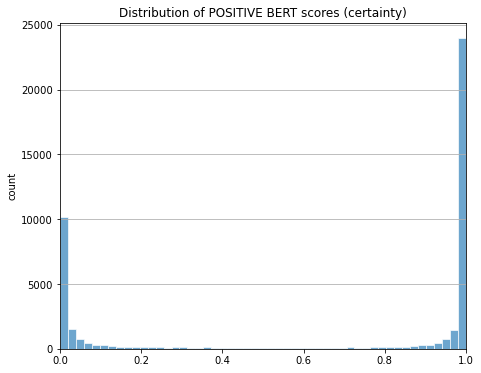

In [14]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
BERT_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax1.set_xlim(0,1)
ax1.set_ylabel("count")
ax1.set_title("Distribution of POSITIVE BERT scores (certainty)")
ax1.xaxis.grid(False)
plt.show()

What seems to be the situation for the BERT scores is that there are more POSITIVE labels that the BERT is super certain about. Before investigating the relation between positive and negative labelled classes we want to rescale the BERT scores to the same scale as the VADER scores, such that they are comparable. Since the BERT scores are outputs of a softmax which generalizes to the sigmoid in the binary case (which we have here) we revert the BERT scores (reverted sigmoid) and scale them to the range -1 to 1.

In [15]:
logBERT = np.log(BERT_scores / (1-BERT_scores))

In [16]:
df['scaledReverted_BERT'] = 2*(logBERT-np.min(logBERT)) / (np.max(logBERT) - np.min(logBERT)) - 1
scaledLogBERT = df['scaledReverted_BERT']

df['scaledReverted_BERT'] = [output_aux(score) for score in tqdm(df.scaledReverted_BERT)]

100%|████████████████████████████████████████████████████████████████████████| 44882/44882 [00:00<00:00, 252587.28it/s]


In [616]:
filename = f"Quotebank_newSentiments_ALL"
df.to_pickle(rf"{data_dir}{os.sep}{filename}.pkl")
print(f"Dataframe was pickled and saved to directory:\n{data_dir} \n")
print(f"Shape of dataframe: {df.shape}")

Dataframe was pickled and saved to directory:
C:\Users\Albert Kjøller\ada-2021-project-f-jab\data 

Shape of dataframe: (44882, 14)


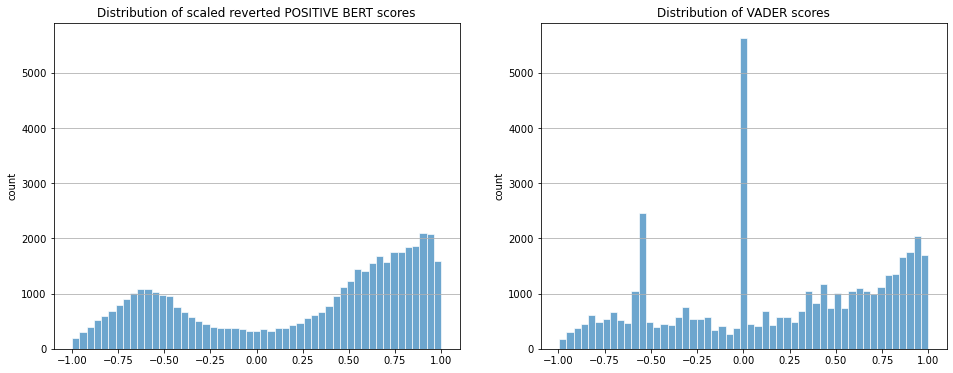

In [17]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
scaledLogBERT.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax1.set_ylabel("count")
ax1.xaxis.grid(False)
ax1.set_title("Distribution of scaled reverted POSITIVE BERT scores")

ax2 = plt.subplot(122, sharey=ax1)
VADER_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax2.set_ylabel("count")
ax2.xaxis.grid(False)
ax2.set_title("Distribution of VADER scores")

plt.show()

So we see that the scores are now comparable and actually look somewhat similar. We still see that very few of the BERT scores are classified as neutral and tend to have the density in a negative and a positive cluster. The two approaches sentiment prediction especially resemble eachother when comparing with the normalized AFINN score in the plot below. We do not scale this to a range of -1 to 1 as it seems to be normally distributed and would therefore be heavily influenced by outliers.

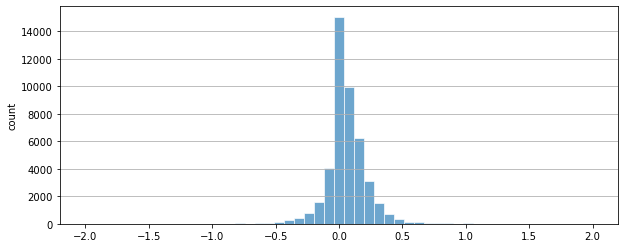

In [18]:
AFINN_scores = pd.Series([score_dict[0]['score'] for score_dict in df.sentiment_AFINN])
AFINN_labels = pd.Series([score_dict[0]['label'] for score_dict in df.sentiment_AFINN])

plt.figure(figsize=(10,4))

ax = plt.subplot(111)
AFINN_scores.hist(edgecolor='white', linewidth=1, bins=51, alpha=0.65)
ax.xaxis.grid(False)
ax.set_ylabel('count')

plt.show()

We now want to examining the mean scores and distribution of labels across the classes "POSITIVE" and "NEGATIVE" to get a sense of how each approach characterizes the quotes. In the below plot we visualize the mean sentiment scores for each approach with a 95% confidence interval as well as the distribution of POSITIVE vs. NEGATIVE labels categorized by each approach. Be aware that the AFINN scores do not make sense to directly compare to the other ones in regards to the continuous score as it is on a different scale, for which reason it is left out.

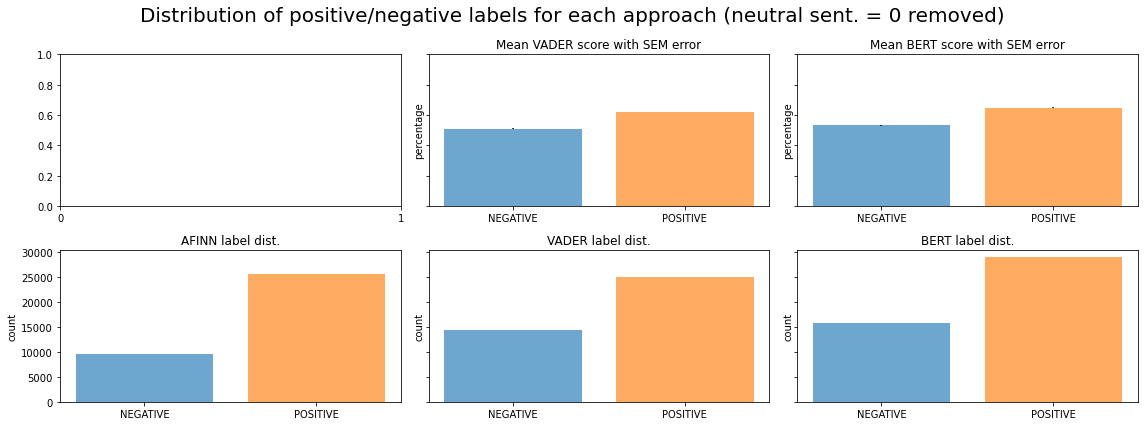

In [19]:
fig, ax = plt.subplots(2,3, figsize=(16,6),sharey='row')

attributes = ["sentiment_AFINN", "sentiment_VADER", "scaledReverted_BERT"]
x = [0,1]    

for i, att in enumerate(attributes):
    sent_scores = pd.Series([score_dict[0]['score'] for score_dict in df[att]])
    sent_labels = pd.Series([score_dict[0]['label'] for score_dict in df[att]])
    ids_without_neutral = -np.logical_and(sent_labels=="POSITIVE", sent_scores==0)
    
    labels, counts = np.unique(sent_labels[ids_without_neutral], return_counts=True)
    temp = pd.DataFrame({'score': sent_scores[ids_without_neutral], 'labels': sent_labels[ids_without_neutral]})
    classes = temp.groupby(by='labels')
    
    err = (1.96*classes.std()/np.sqrt(sum(counts))).T.to_numpy()[0]
    
    ax[0, i].set_xticks(x)       
    if i != 0:
        ax[0, i].bar(x, abs(classes.mean().T.to_numpy()[0]), yerr=abs(err), color=['C0', 'C1'], alpha=0.65)
        ax[0, i].set_xticklabels(labels)
        ax[0, i].set_title(f"Mean {att.split('_')[1]} score with SEM error")
        ax[0, i].set_ylim(0,1)
        ax[0, i].xaxis.grid(False)     
        ax[0, i].set_ylabel("percentage")
        
    ax[1, i].bar(x, counts, color=['C0', 'C1'], alpha=0.65)
    ax[1, i].set_xticks(x)
    ax[1, i].set_xticklabels(labels)
    ax[1, i].set_title(f"{att.split('_')[1]} label dist.")
    ax[1, i].xaxis.grid(False)
    ax[1, i].set_ylabel("count")


plt.suptitle("Distribution of positive/negative labels for each approach (neutral sent. = 0 removed)", fontsize=20)
plt.tight_layout()
plt.show()

The first row of the above subplot reveals that the scores obtained with VADER and BERT are similar. The second row reveals that there is an overweight of the POSITIVE label no matter which approach is used - also when the sentiment scores equal to 0 are removed. Furthermore, this reveals the first thing about the sentiment of quotes about movies - namely that there is a slight overweigth of positively associated quotes. Lets investigate the labels of one approach when conditioning on the other (between VADER and BERT).

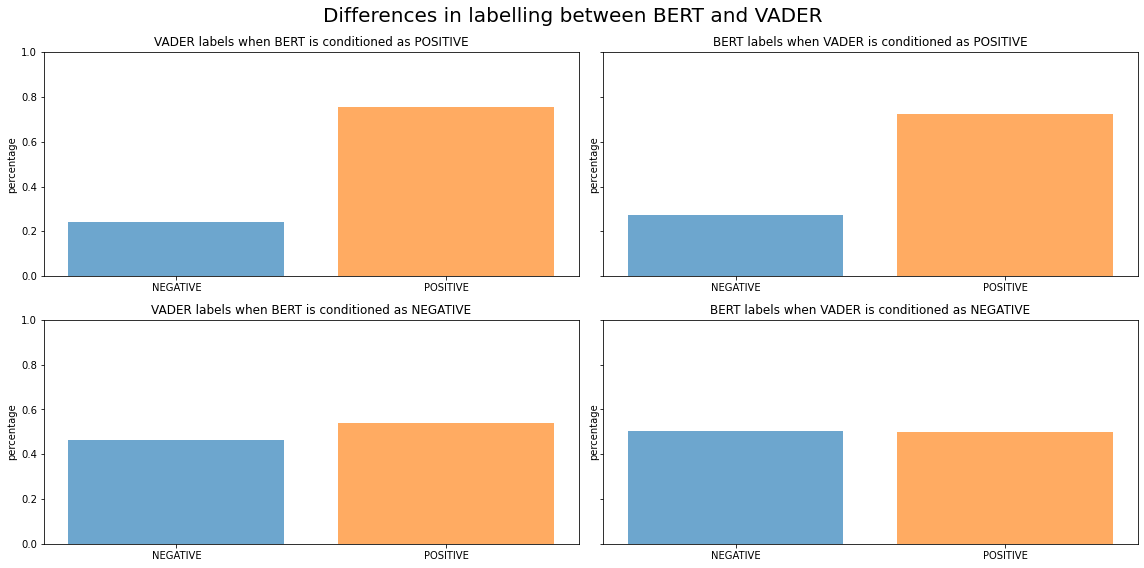

In [20]:
fig, ax = plt.subplots(2, 2, figsize=((16,8)), sharey=True)
x = [0, 1]

helper_dict = {"sent1": [(VADER_labels, "VADER"), (VADER_labels, "VADER"), (BERT_labels, "BERT"), (BERT_labels, "BERT")], 
              "sent2": [(BERT_labels, "BERT"), (BERT_labels, "BERT"), (VADER_labels, "VADER"), (VADER_labels, "VADER")],
              "category": ["POSITIVE", "NEGATIVE", "POSITIVE", "NEGATIVE"]}

for i in range(4):
    data = helper_dict["sent1"][i][0][helper_dict["sent2"][i][0] == helper_dict["category"][i]]
    labels, counts = np.unique(data, return_counts=True)
    

    ax[i%2, i//2].bar(x, counts/np.sum(counts), color=['C0', 'C1'], alpha=0.65)
    ax[i%2, i//2].set_xticks(x)
    ax[i%2, i//2].set_xticklabels(labels)
    ax[i%2, i//2].set_ylim(0, 1)    
    ax[i%2, i//2].set_title(f"{helper_dict['sent1'][i][1]} labels when {helper_dict['sent2'][i][1]} is conditioned as {helper_dict['category'][i]}")
    ax[i%2, i//2].set_ylabel("percentage")
        
plt.suptitle("Differences in labelling between BERT and VADER", fontsize=20)
plt.tight_layout()
plt.show()

As we see on the first row of the above subplots the two approaches seem to agree in around 80% of the cases for both approaches when conditioning on the POSITIVE classifications from the other approach. Contrarily we see that both approaches do not agree as much on the NEGATIVE class - in fact there are even more POSITIVE labels using the VADER approach compared to the NEGATIVE labels when we condition and use the quotes from labelled as NEGATIVE by the transformer. We can get a sence of why this is the case when conditioning on the scores of the VADER approach. We investigate this in two manners; 1) by a comparative plot, and 2) by looking at concrete quotes when the labelling from BERT and VADER differ.

In [518]:
from matplotlib.colors import to_rgb

def plotWithCondition(df, conditional_attribute, second_attribute, cond_bound=(-1,1), BERT_bound=(0, 1), movie=None):
        
    if movie != None:
        movie_slice = (df.movie == movie)    
        BERT_scores = pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])[movie_slice]
        scaledLogBERT = pd.Series([score_dict[0]['score'] for score_dict in df['scaledReverted_BERT']])[movie_slice]   
        cond_scores = pd.Series([score_dict[0]['score'] for score_dict in df[conditional_attribute]])[movie_slice]
        movie_title = movie

    else:
        BERT_scores = pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])
        scaledLogBERT = pd.Series([score_dict[0]['score'] for score_dict in df['scaledReverted_BERT']])   
        cond_scores = pd.Series([score_dict[0]['score'] for score_dict in df[conditional_attribute]])
        movie_title = "All movies"
    
    condition = np.logical_and(cond_scores >= cond_bound[0], cond_scores < cond_bound[1])
    cond_name = conditional_attribute.split('_')[1]
    second_name = second_attribute.split('_')[1]
    
    fig = plt.figure(figsize=(16,6))
    fig.suptitle(f"\"{movie_title}\" ", fontsize=20)

    # plot of conditional attribute (VADER)
    ax1 = plt.subplot(221)
    _, bins, patches = ax1.hist(cond_scores, edgecolor='white', linewidth=1, bins=51, alpha=0.65, density=True)
    ax1.set_title(f"Distribution of {cond_name} scores \n Condition (orange) = [{cond_bound[0], cond_bound[1]}]")
    ax1.set_ylabel('density', fontsize=12)
    
    bins_lower = np.where(bins >= cond_bound[0] - 0.02)[0]
    bins_upper = np.where(bins <= cond_bound[1])[0]
    
    idxs = np.intersect1d(bins_lower, bins_upper)
    for idx in idxs[:-1]:
        patches[idx].set_facecolor('C1')
      
    # BERT probability of positive label plot
    ax2 = plt.subplot(122)
    _, bins, patches = ax2.hist(BERT_scores[condition], edgecolor='white', linewidth=1, bins=51, alpha=0.65, density=True)
    ax2.set_title(f"BERT density of positive label")
    ax2.set_ylabel('density', fontsize=14)    

    # plot of scaled and reverted BERT scores
    ax3 = plt.subplot(223, sharex=ax1)
    _, bins, patches = ax3.hist(scaledLogBERT[condition], edgecolor='white', linewidth=1, bins=51, alpha=0.65, density=True)
    ax3.set_title(f"Scaled, reverted {second_name} scores \n Condition (lightblue) = [{BERT_bound[0], BERT_bound[1]}]")
    ax3.set_ylabel('density', fontsize=12)
    ax3.set_xlim(-1.1,1.1)
    
    bins_lower = np.where(bins >= BERT_bound[0] - 0.02)[0]
    bins_upper = np.where(bins <= BERT_bound[1])[0]
    
    idxs = np.intersect1d(bins_lower, bins_upper)
    colour = to_rgb('skyblue')
    #colour[2] = 0.5
    for idx in idxs[:-1]:
        patches[idx].set_facecolor(colour)
    

    ax1.xaxis.grid(False)
    ax1.yaxis.grid(True)
    ax2.xaxis.grid(False)
    ax2.yaxis.grid(True)
    ax3.xaxis.grid(False)
    ax3.yaxis.grid(True)

    plt.tight_layout()
    plt.show()

In [304]:
def printConditionQuotes(df, first_attribute, second_attribute, N=3, first_bound=(-1,-0.5), second_bound=(0.5, 1), movie=None):
    
    if movie != None:
        movie_slice = (df.movie == movie)    
        first_scores = pd.Series([score_dict[0]['score'] for score_dict in df[first_attribute]])[movie_slice]
        second_scores = pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])[movie_slice]
        movie_title = movie

    else: 
        first_scores = pd.Series([score_dict[0]['score'] for score_dict in df[first_attribute]])
        second_scores = pd.Series([score_dict[0]['score'] for score_dict in df[second_attribute]])
        movie_title = "All movies"
    
    first_condition = np.logical_and(first_scores >= first_bound[0], first_scores < first_bound[1])
    second_condition = np.logical_and(second_scores >= second_bound[0], second_scores < second_bound[1])
    
    first_name = (" ").join(conditional_attribute.split('_'))
    second_name = (" ").join(second_attribute.split('_'))
    
    both_conds = np.logical_and(first_condition, second_condition)
    indeces_conds = first_scores.loc[both_conds].index
    
    random_quotes = np.random.permutation(indeces_conds)[:N]
    #random_quotes = np.random.choice(indeces_conds)
        
    print(f"Analyzing {N} randomly chosen quotes given that satisfy following conditions. \nConditions: {first_name} = {first_bound}, {second_name} = {second_bound}")
    for i in range(N):
        print(f"\nQuote w. index {random_quotes[i]}:\n {df.loc[random_quotes[i]].quotation}")
    


The following will first investigate the BERT scores when the VADER scores are either negative or strongly negative as well as give examples of quotes where the approaches disagree (in positive/negative labelling).

Afterwards the same investigation will be done conditioning on positive or strongly positive VADER scores.


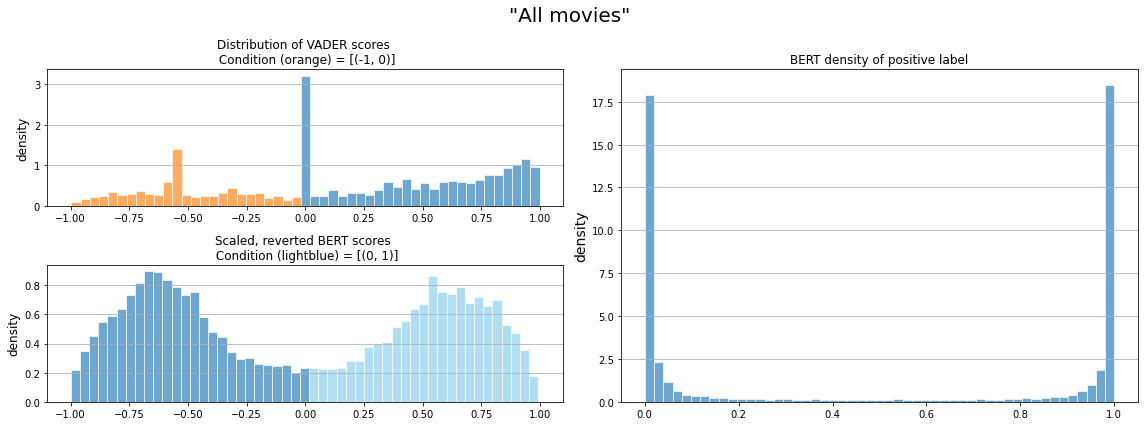

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: sentiment VADER = (-1, 0), positive BERT = (0.5, 1)

Quote w. index 4175:
 twenty more years of Star Wars movies, toys, comic books, weapons programs, video games, trailers, promos -- and tons of New Age jive to link it all up with Homer, the Old Testament, Virgil, the Qu' ran, Arthurian legend, Joseph Campbell and even Walt Disney.

Quote w. index 36572:
 LEGO Star Wars Visual Dictionary New Edition

Quote w. index 14778:
 every Star Wars fans' dream.

Quote w. index 30589:
 From putting T.S. Eliot in the captain's tower, to hanging out with Allen Ginsburg, to hiring Sam Shepard to document a tour, to stealing from a Civil War poet, he makes you think about those things in the same place,

Quote w. index 32309:
 Eventually, we would also like to focus on the War of 1812 and the Civil War in our region. There's a lot of history here.


In [529]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="sentiment_VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,0), BERT_bound=(0,1))

printConditionQuotes(df, first_attribute="sentiment_VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, 0), second_bound=(0.5, 1))

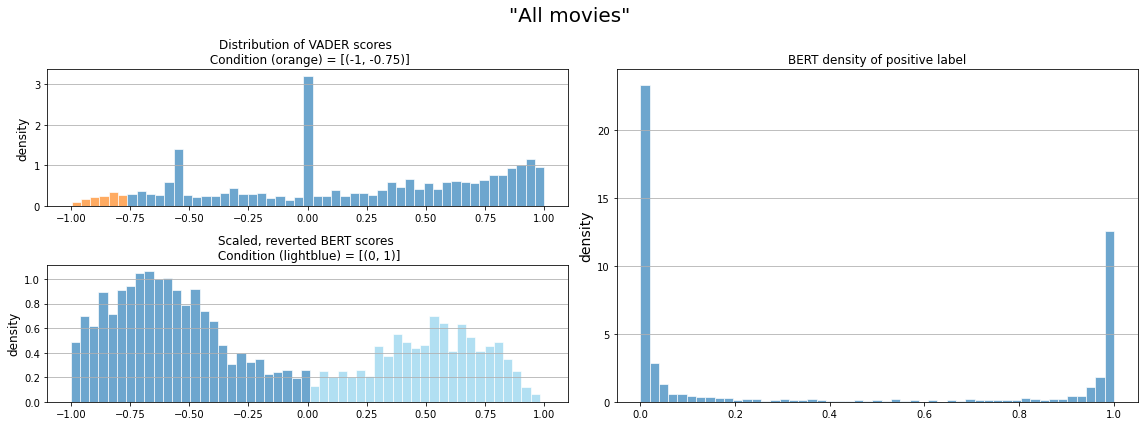

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: sentiment VADER = (-1, -0.75), positive BERT = (0.5, 1)

Quote w. index 15073:
 We've heard of the man they call Star Wars. Ugh. Yes, Star Wars. He's all of Star Wars... We've heard of the movie Star Wars.

Quote w. index 31759:
 We found out (Bacheler) was a Civil War veteran and as a prisoner of war, he escaped Libby Prison,

Quote w. index 13836:
 Electronica for a killer car. Most of the sound track for Christine was 1950's rock'n roll (with a main title appearance of George Thorogood and the Destroyers' `Bad to the Bone' ). I filled in where necessary.

Quote w. index 26003:
 Our goal was to complete all of our emergency operations with no one getting hurt or killed. Mission accomplished thanks to the evacuations and the hard work from fire, police, and DPW workers.

Quote w. index 32081:
 When Gareth speaks about Rogue One, he spoke about it in terms of a war movie. And he compares it to othe

In [531]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="sentiment_VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,-0.75), BERT_bound=(0,1))

printConditionQuotes(df, first_attribute="sentiment_VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, -0.75), second_bound=(0.5, 1))

**Comments:**
From the first of the two conditionings above we see that the BERT score are labelled negative almost as frequently as positive when looking at all quotes classified as negative by VADER (VADER score below 0). So the two approaches disagree on half of the labels classified as negative by VADER. From the second conditioning we see that this tendency reduces when looking at the strongly negative quotes classified by VADER where the BERT distribution gets more negative as well but still labels a large amount of the (negative by VADER) quotes as positive.

From the randomly chosen quotes we realize that Star Wars or in general the word "War" occur a lot in the quotes - especially for the strongly negative quotes. We will get back to this later.

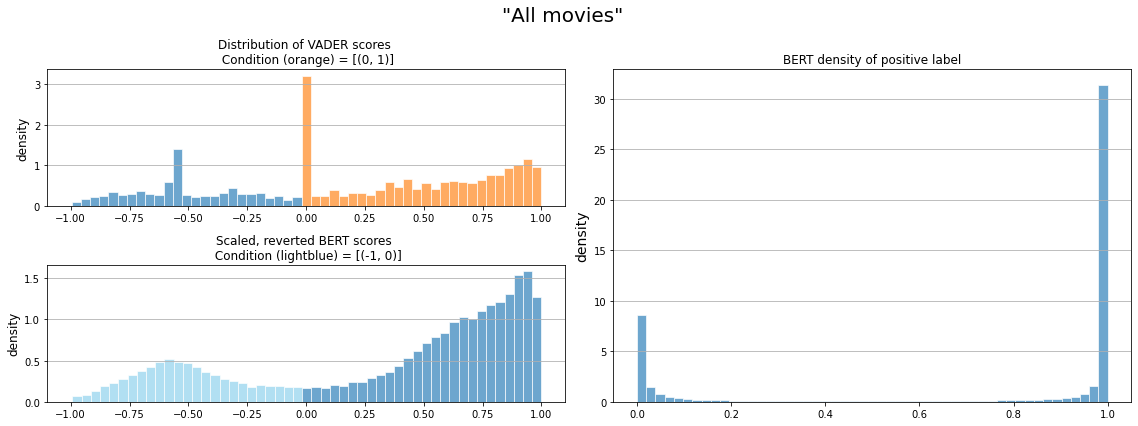

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: sentiment VADER = (0, 1), positive BERT = (0, 0.5)

Quote w. index 24690:
 I actually enjoyed the black-eyed pea burger more than the Impossible Burger, and I did not enjoy the black-eyed pea burger at all.

Quote w. index 43890:
 I used that as a baseline for so many `Spider-Man' moments.

Quote w. index 17428:
 For me, I was entirely focused on Episode VIII and having this experience,

Quote w. index 13732:
 There's a new Iron Spider. We don't know who's in that costume. But when you find out, if you're a Miles fan or a Spider-Man fan in general, it will blow your mind,

Quote w. index 39336:
 somewhere after the events of The Last Jedi and shortly before Episode IX.


In [532]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="sentiment_VADER", second_attribute="positive_BERT",
                  cond_bound=(0,1), BERT_bound=(-1,0))

printConditionQuotes(df, first_attribute="sentiment_VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0, 1), second_bound=(0, 0.5))

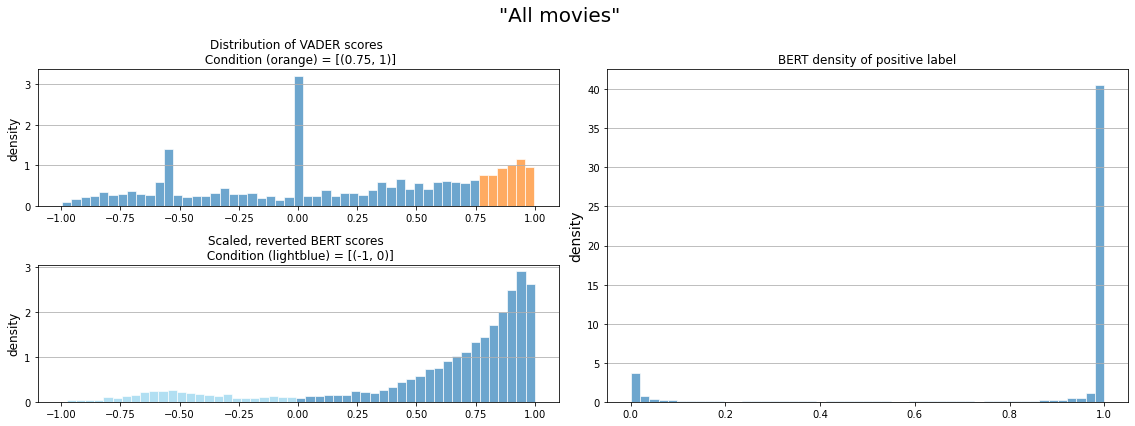

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: sentiment VADER = (0.75, 1), positive BERT = (0, 0.5)

Quote w. index 4778:
 Phase One ended with' Avengers.' So some people thought that Phase Two would end with an `Avengers' film. But the truth is, there is so much in `Ant-Man' : introducing a new hero, introducing a very important part of technology in the Marvel universe, the Pym particles. Ant-Man getting on the Avengers' radar in this film and even - this is the weirdest part, you shouldn't really talk about it because it won't be apparent for years-but the whole notion of the quantum realm and the whole notion of going to places that are so out there, they are almost mind-bendingly hard to fathom. It all plays into Phase Three. It became very clear that Ant-Man is the pinnacle and finale of Phase Two and' Captain America: Civil War' is the start of Phase Three.

Quote w. index 28130:
 No matter how much money or how many awards films like `

In [533]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="sentiment_VADER", second_attribute="positive_BERT",
                  cond_bound=(0.75,1), BERT_bound=(-1,0))

printConditionQuotes(df, first_attribute="sentiment_VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0.75, 1), second_bound=(0, 0.5))

**Comments:** 
On the other hand the tendency is remarkably different when conditioning on the positively labelling by VADER of the scores. For positively labelled quotes by VADER, BERT generally agrees but labels a small amount of quotes as negative. However, when VADER predicts quotes strongly positive, almost all of the BERT predicitons are positive too.

With regards to the random outputted examples it seems like "War" doesn't occur as much and that the quotes are in general longer than the mistakes when conditioning with negative VADER predicions. However, we are aware that the randomly outputted 5 quotes are not representative for all of the disagreeing labelled quotes.

We will now look at the representation of the movies when checking the above conditions to investigate whether there is a trend between the disagreeing of the labelling of quotes and the movies they concern. The following function is used for analyzing this through horizontal bar plots.

In [612]:
def barplotWithCondition(df, VADER_bounds, BERT_bounds):

    BERT_scores = pd.Series([score_dict[0]['score'] for score_dict in df["positive_BERT"]])
    cond_scores = pd.Series([score_dict[0]['score'] for score_dict in df["sentiment_VADER"]])
    VADER_statement = np.logical_and(VADER_scores > VADER_bounds[0], VADER_scores < VADER_bounds[1])
    BERT_statement = np.logical_and(BERT_scores > BERT_bounds[0], BERT_scores < BERT_bounds[1])

    condition = np.logical_and(VADER_statement, BERT_statement)

    title, count = np.unique(df.movie[condition], return_counts=True)
    count, title = np.array(list(zip(*sorted(zip(count, title), reverse=False))))
    count = np.array([int(number) for number in count])

    plt.figure(figsize=(16,10))
    plt.title(f"Quotes about movies \n VADER condition: {VADER_bounds}, BERT condition: {BERT_bounds}", fontsize=20)
    plt.xlabel("count", fontsize=12)
    plt.barh(title, count, alpha=0.65)
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

We start by visualizing the unconditioned distribution of movies to have as a comparison.

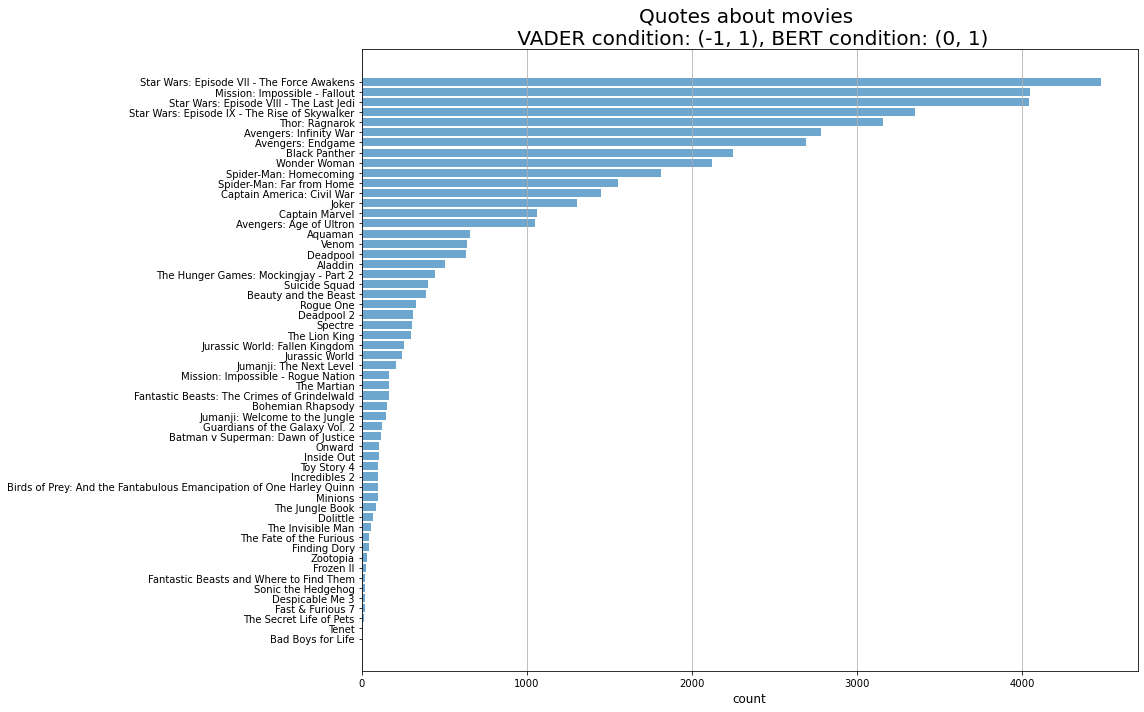

In [613]:
barplotWithCondition(df, VADER_bounds=(-1, 1), BERT_bounds=(0, 1))

Then we do the investigation with the same condition as in the previous investigation where we first look at the negatively labelled VADER predictions.

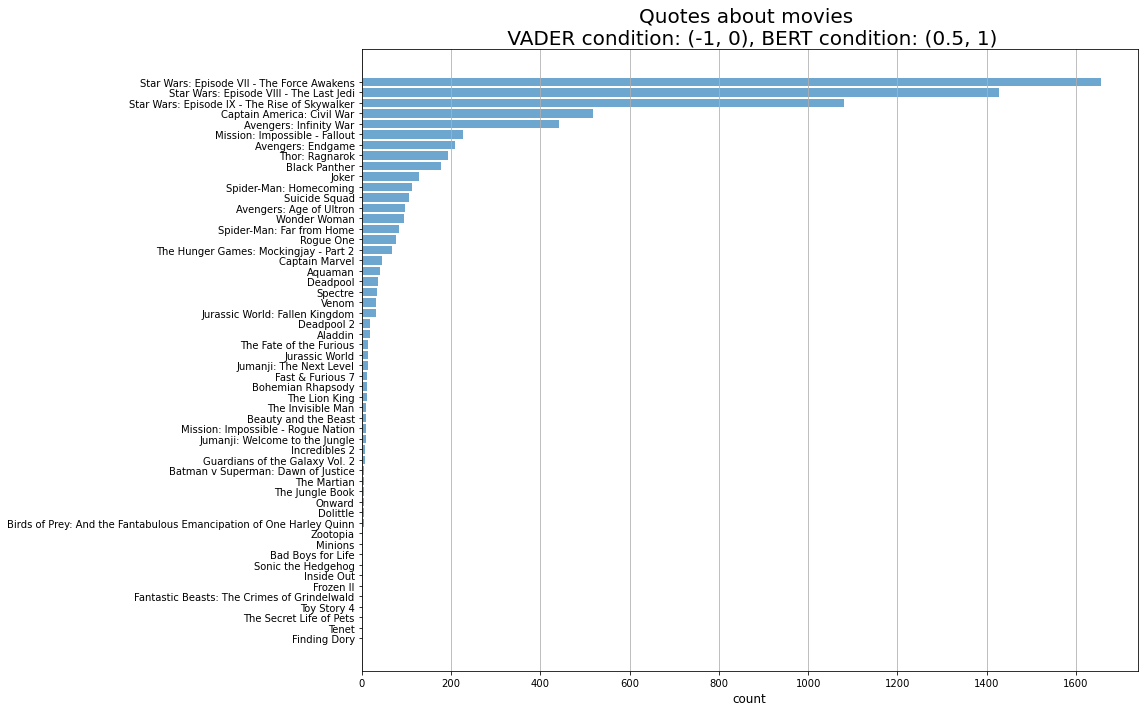

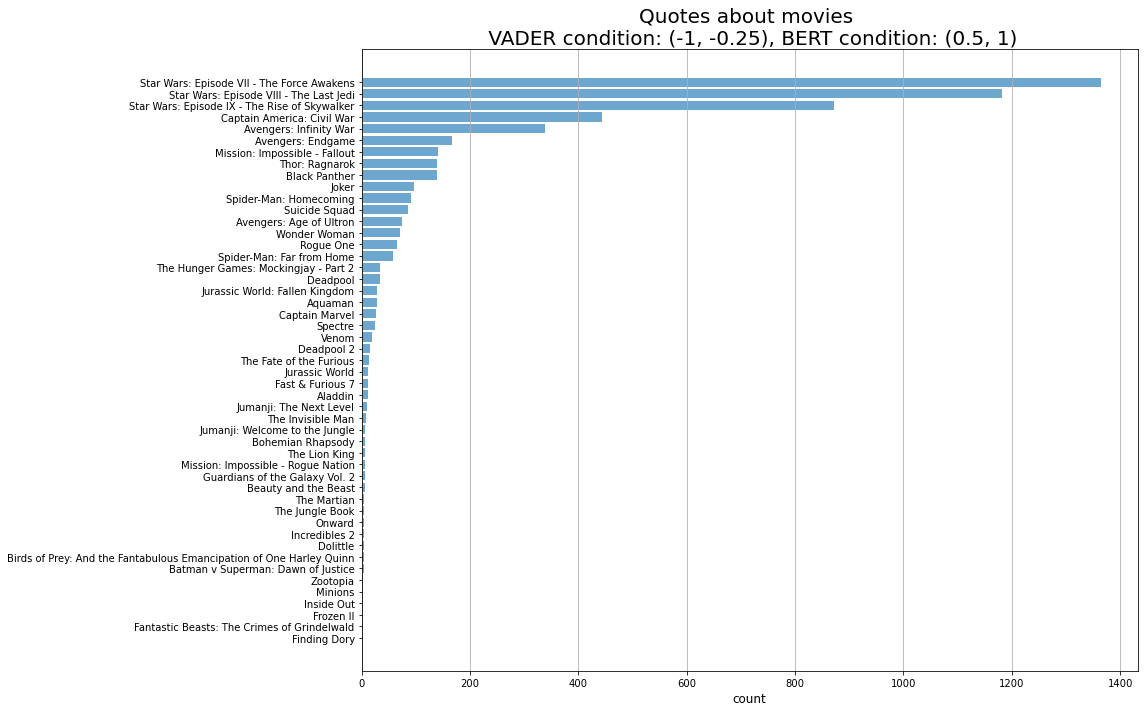

In [614]:
barplotWithCondition(df, VADER_bounds=(-1, 0), BERT_bounds=(0.5, 1))
barplotWithCondition(df, VADER_bounds=(-1, -0.25), BERT_bounds=(0.5, 1))

Even though Star Wars and other movie titles that have a negative title are quite highly represented without conditioning on the data it still seems like conditioning on negative VADER labels exagerates this tendency. Also it seems like the above plot (conditioning on negative VADER) kind of ranks the scores from most negatively to most positively associated movie title. In other words negative VADER labels that are positively labelled by the transformer in general concern movies with negative titles. Even though this tendency sounds like a good feature of the VADER approach we do not prefer this to the BERT as we do not want the sentiment score to reflect the sentiment of the movie title but rather the context in which it appears.

As we see below, there is not the same tendency for the disagreeing labelling when conditioning on positive VADER labels - it ressembles the original distribution more even though it is hard to say as we have a lot fewer data points with this conditioning.

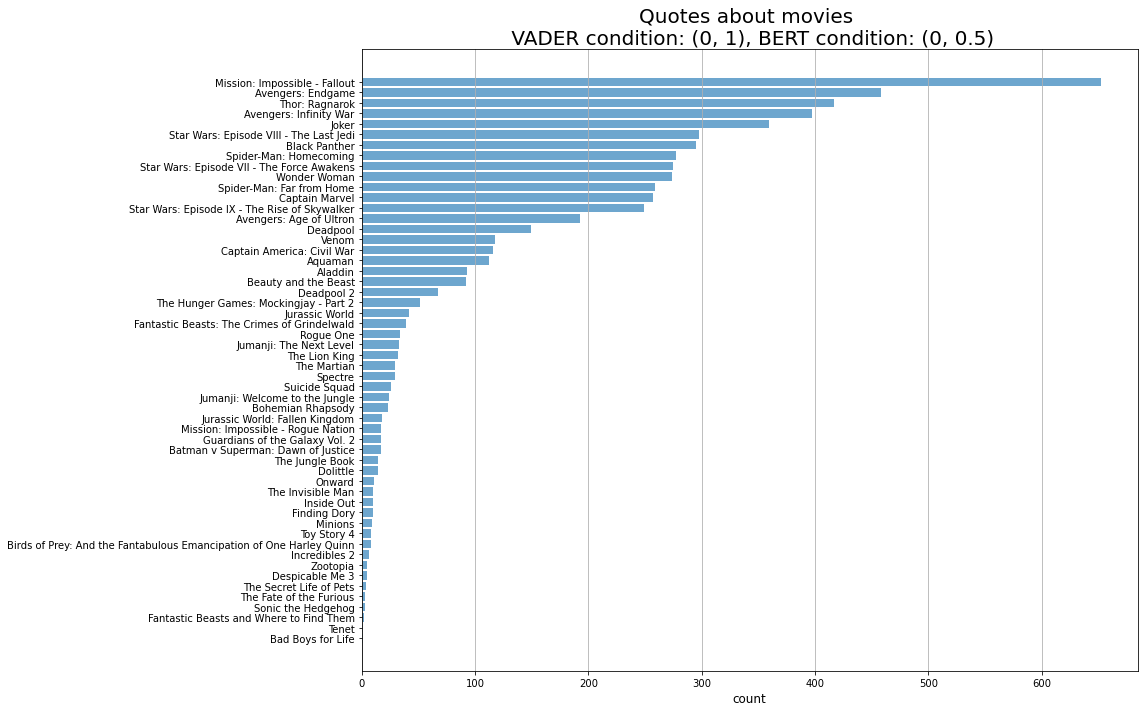

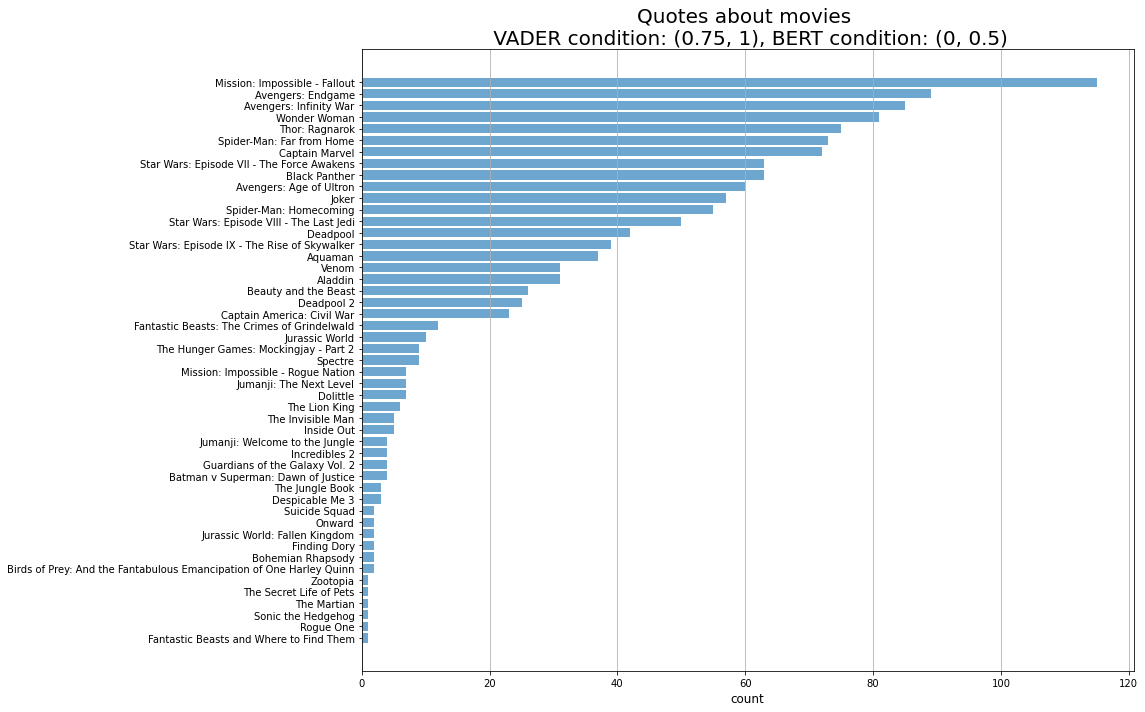

In [615]:
barplotWithCondition(df, VADER_bounds=(0, 1), BERT_bounds=(0, 0.5))
barplotWithCondition(df, VADER_bounds=(0.75, 1), BERT_bounds=(0, 0.5))

### Discussion and comments on different sentiment scores

Both approaches have pros and cons - here is a summary of them and an evaluation of which approach will be used as the main one for the future investigations.

VADER seems to struggle with interpreting larger semantical structures in the sentence compared to the transformer based labelling which was seen through conditioning plots of score and movie title distributions and the qualitative analysis of quotes that has different labels with the two approaches. This conclusion is based on the fact that strongly negative scores from the VADER approach are labelled almost equally much as positive or negative with the BERT transformer approach. Through further conditioning investigations we saw that the quotes causing a difference in labelling between the two approaches tend to concern specific movies or the length of the quote (depending on whether positive or negative conditions were used). For instance, it seems like the thing that causes BERT to label many of the quotes labelled as strongly negative by VADER is that VADER does not catch the semanticly neutral sentiment of the word "War" when "War" is part of a movie title where BERT does not associate a negative sentiment with this. 

On the other hand, BERT predicts using the probability outcome of a softmax function and is in general very certain about its predictions. This mean that it does not make sense to infer a neutral sentiment assignment with this pretrained BERT transformer which is definetely a con of the transformer approach as not all quotes need to be associated with EITHER a positive or a negative score.

Anyhow, we choose to continue with the transformer-based approach as it - as seen from initial analyses - is able to capture a more valid semantical understanding of quotes, which we weigh higher than the ability to do a neutral classification. We will however keep both but prioritize the BERT for further analyses. 

### AD(A)itional feature

Also applicable on the movie level - for instance we can analyze the same trends on the Top 2 most quoted movies.

In [617]:
title, count = np.unique(df.movie, return_counts=True)
count_sorted, title = np.array(list(zip(*sorted(zip(count, title), reverse=True))))

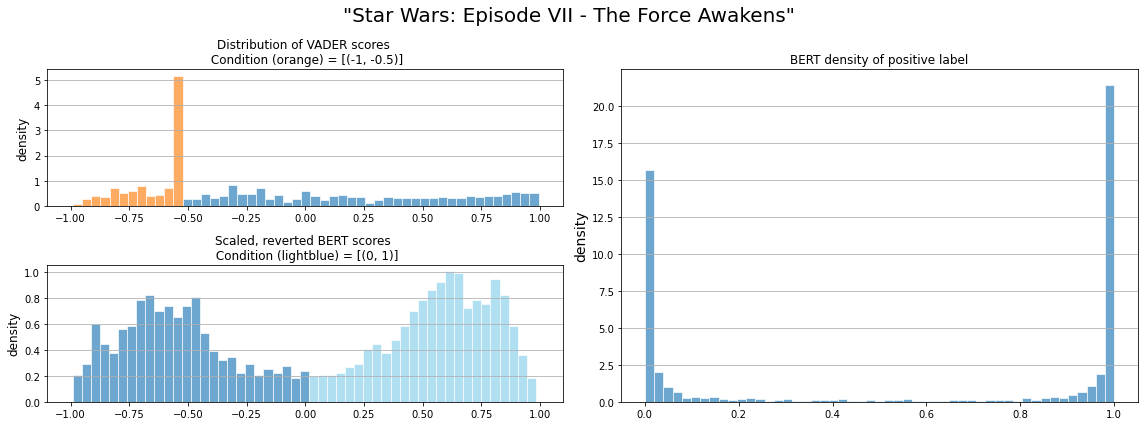

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: sentiment VADER = (-1, 0.75), positive BERT = (0.5, 1)

Quote w. index 2112:
 when I began working on the `Spider-Man' films and our visual effects supervisor was John Dkystra, the VFX supervisor on `Star Wars.' I was working with a legend. it was so much fun and surreal in reviews and dailies listening to old war stories from `Star Wars' that he would relate.

Quote w. index 3846:
 Where other companies were quick to issue cease and desist orders, Star Wars is a very open universe and Lucasfilm encouraged fans to play in it,

Quote w. index 4716:
 I love Star Wars, too,

Quote w. index 5645:
 Star Wars' first ever female villain

Quote w. index 7262:
 I am an enormous enthusiast of Star Wars.... be that as it may, I think it was never in my stars for me to direct one,


In [618]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="sentiment_VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,-0.5), BERT_bound=(0,1), 
                  movie=title[0])

printConditionQuotes(df, first_attribute="sentiment_VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, 0.75), second_bound=(0.5, 1),
                     movie=title[0])

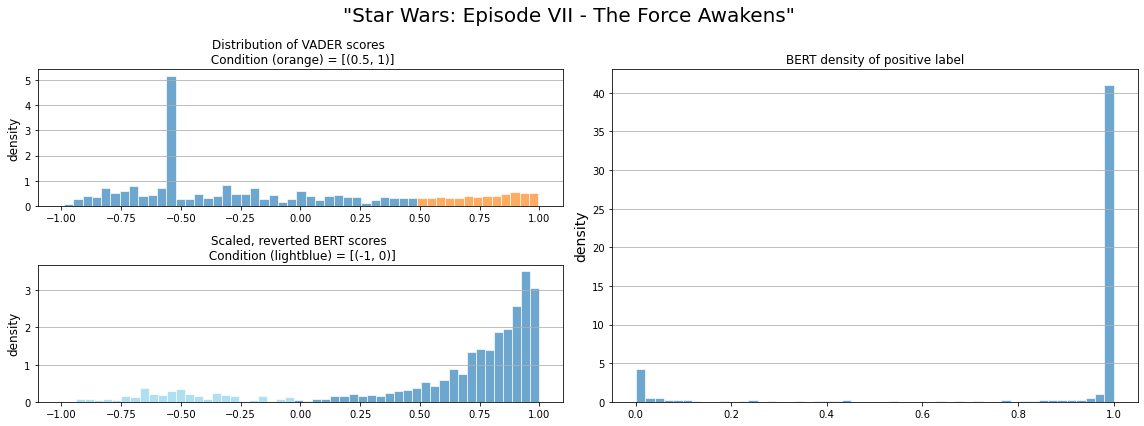

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: sentiment VADER = (0.5, 1), positive BERT = (0, 0.5)

Quote w. index 1499:
 Obviously there's something politically within but I know that they were in preproduction heavily. I know that the options for Olivia [ Wilde ] and Garrett [ Hedlund ] were picked up. That was all public knowledge, [ reported in ] The Hollywood Reporter. I've got a feeling they're going to play it safe with their old [ formula ]. I mean, Tim Burton's doing Dumbo. They're going to make live-action out of their old animated classics. Apparently, that was successful. They also have Star Wars. Let's not neglect that, and Marvel. Maybe they just felt they had enough of that sci-fi. We were the only real science fiction. Star Wars is fantasy, sword and sorcery fantasy with a spaceship. Marvel is superhero comics. Star Wars, yes, is science fiction. There's fantasy elements as well, but Marvel is not. It's comic books. It's really

In [619]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="sentiment_VADER", second_attribute="positive_BERT",
                  cond_bound=(0.5,1), BERT_bound=(-1,0), 
                  movie=title[0])

printConditionQuotes(df, first_attribute="sentiment_VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0.5, 1), second_bound=(0, 0.5),
                     movie=title[0])

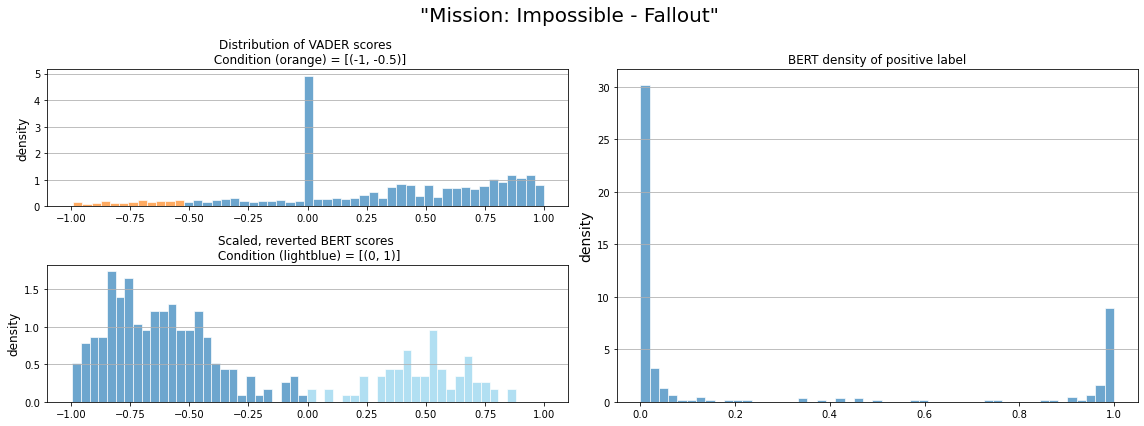

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: sentiment VADER = (-1, 0.75), positive BERT = (0.5, 1)

Quote w. index 27433:
 Prime Minister Narendra Modi is spearheading the National Mobility Mission, 2020, to control rising temperature and pollution. Maharashtra, too, has its own policy to encourage electrical vehicles. At a time when automobile companies are manufacturing electrical vehicles, charging stations are going to be a much-needed facility.

Quote w. index 23592:
 Nigeria is a high-priority for World Mission when it comes to sending our solar-powered audio Bibles, particularly in the Hausa language,

Quote w. index 27157:
 The US Mission in India extends our deepest condolences to the family of former Prime Minister Vajpayee and the citizens of India,

Quote w. index 29246:
 Legitimate art stuff was in North Beach; we never thought it would make it into the Mission. Most of the artists were young with no money. The stakes weren't th

In [620]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="sentiment_VADER", second_attribute="positive_BERT",
                  cond_bound=(-1,-0.5), BERT_bound=(0,1), 
                  movie=title[1])

printConditionQuotes(df, first_attribute="sentiment_VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(-1, 0.75), second_bound=(0.5, 1),
                     movie=title[1])

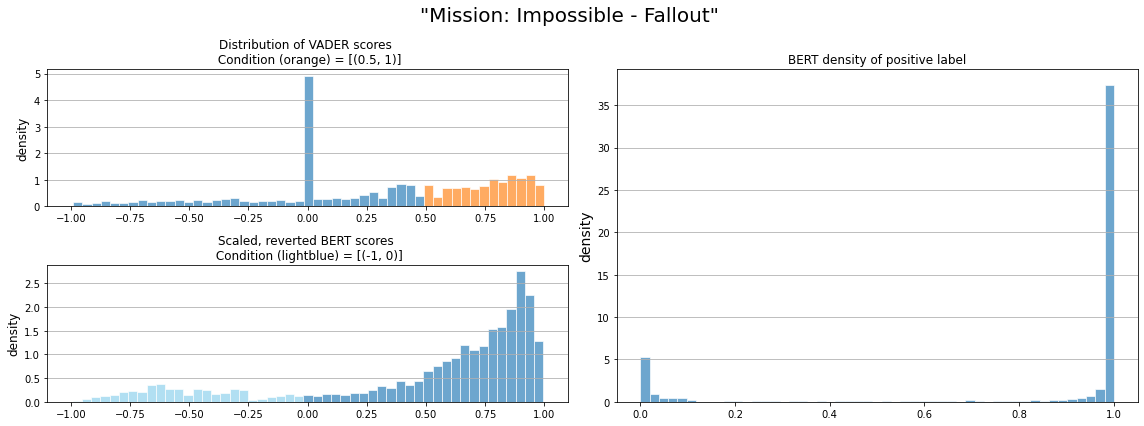

Analyzing 5 randomly chosen quotes given that satisfy following conditions. 
Conditions: sentiment VADER = (0.5, 1), positive BERT = (0, 0.5)

Quote w. index 23900:
 There's going to be some games which have a million controls and a lot going on where it's not practical to cater straight out of the box. But it should cater to your basic big headline games like your Fallouts and your Halos.

Quote w. index 28364:
 It's super important for a movie like `Mission' to be doing it all practically and for real,

Quote w. index 30238:
 We are thankful that you accepted our invitation to attend our programme celebrating the 125th anniversary of the Parliament of World's Religions, which was to be held at the Art Institute of Chicago on August 26. We are sorry to inform you that due to the sudden demise of Swami Abhiramananda, Assistant General Secretary, Trustee of Ramakrishna Mission and member of the Governing Body of Ramakrishna Mission, as well as unforeseen difficulties, we have had to can

In [621]:
# The conditional attribute can eventually be changed to the df.sentiment_AFINN or any other attribute with same data structure
plotWithCondition(df, conditional_attribute="sentiment_VADER", second_attribute="positive_BERT",
                  cond_bound=(0.5,1), BERT_bound=(-1,0), 
                  movie=title[1])

printConditionQuotes(df, first_attribute="sentiment_VADER",
                     second_attribute="positive_BERT", 
                     N=5, first_bound=(0.5, 1), second_bound=(0, 0.5),
                     movie=title[1])

Having created the sentiment score in preprocessing, we now just check for the two quotes with minimum (i.e. most negative) and maximum (i.e. most positive) sentiment according to the VADER and BERT sentiment lexicon. 

In [608]:
print("Quote with minimum VADER sentiment:\n")
print(df.loc[VADER_scores.argmin()].quotation)

Quote with minimum VADER sentiment:

Mockingjay, may your aim be as true as your heart is pure. „ ~ The end of Coin's hypocritical speech during Snow's execution-her last words. During the 75th Hunger Games, President Coin starts the second rebellion against the Capitol to take control over Panem. As she needs Katniss Everdeen for her unique position as a symbol of rebellion to the districts, she rescues her, Finnick Odair and Beetee from the arena and hide them in District 13. This caused the Capitol to bomb District 12, Katniss's home, but Coin showed little emotion to this. However, Coin soon discovers it is hard to cooperate with Katniss, who dislikes her for her selfishness and ruthlessness. Coin often regrets openly she couldn't have saved the more charismatic Peeta from the arena instead of Katniss. Before the attack on the Capitol, Coin realizes Katniss could menace her position of President, as people still love Katniss more than her. To destroy her rival's psyche completely, 

In [609]:
print("Quote with maximum VADER sentiment:\n")
print(df.loc[VADER_scores.argmax()].quotation)

Quote with maximum VADER sentiment:

Starring in Avengers: Infinity War is BAFTA Award nominee Chris Hemsworth as Thor, Academy Award nominee Josh Brolin as Thanos, Saturn Award Winner Chris Pratt as Star Lord / Peter Quill, Teen Choice Awards nominee Sebastian Stan as Bucky, four-time Golden Globe Award nominee Scarlett Johansson as Natasha Romanoff / Black Widow, Academy Award nominee Benedict Cumberbatch as Dr. Stephen Strange, Academy Award winner Brie Larson as Carol Danvers / Captain Marvel, ALMA Award winner Zoe Saldana as Gamora, Empire Award winner Karen Gillan as Nebula, two-time Academy Award nominee Jeremy Renner as Clint Barton / Hawkeye, two-time Saturn Award nominee Chris Evans as Steve Rogers / Captain America, BAFTA Awards nominee Elizabeth Olsen as Wanda Maximoff / Scarlet, four-time Academy Award nominee Bradley Cooper as Rocket Raccoon, Screen Actors Guild Awards nominee Vin Diesel as Groot, Academy Award nominee Samuel L. Jackson as Nick Fury, Screen Actors Guild A

In [610]:
print("Quote with minimum BERT sentiment:\n")
print(df.loc[BERT_scores.argmin()].quotation)

Quote with minimum BERT sentiment:

To say I'm gutted is understatement. Truly disappointed in this movie. There are so many plot holes, and missed opportunities it is unreal. Also no cohesion with pretty much any of the previous Star Wars movies, including The Force Awakens. A complete mess and a middle finger to all who created Star Wars.


In [611]:
print("Quote with maximuma BERT sentiment:\n")
print(df.loc[BERT_scores.argmax()].quotation)

Quote with maximuma BERT sentiment:

To work on Fantastic Beasts is a wonderful musical opportunity,
